## Модуль 5.1 - Рекомендательные системы
<b>Цель</b> - увеличить средний чек продаж магазина путем создания рекомендательной системы товаров для пользователей.

<b>Задачи:</b>
- провести анализ датасета (EDA),
- подготовить признаки для обучения модели, 
- обучить модель рекомендательной системы,
- протестировать модель,
- сделать submit на Kaggle.

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

G:\soft\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Получаем данные

In [2]:
df = pd.read_csv('data3/train.csv', low_memory=False)

In [3]:
df.head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,True,"10 4, 2016",Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,True,"03 1, 2016",Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,True,"06 26, 2016",DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,True,"09 5, 2013",Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,True,"09 14, 2016",Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [4]:
df.shape

(857895, 12)

## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   verified        857895 non-null  bool   
 1   reviewTime      857895 non-null  object 
 2   reviewerName    857719 non-null  object 
 3   reviewText      857616 non-null  object 
 4   summary         857725 non-null  object 
 5   unixReviewTime  857895 non-null  int64  
 6   vote            118740 non-null  object 
 7   style           444406 non-null  object 
 8   image           7142 non-null    object 
 9   userid          857895 non-null  int64  
 10  itemid          857895 non-null  int64  
 11  rating          857895 non-null  float64
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 72.8+ MB


In [6]:
# Удалим дубликаты, т.к. пользователь может оценить один товар один раз.
df.drop_duplicates(inplace=True)
df.shape

(826895, 12)

In [7]:
# Посмотрим на пропущенные значения
df.isna().sum()

verified               0
reviewTime             0
reviewerName         164
reviewText           274
summary              166
unixReviewTime         0
vote              712944
style             398698
image             819916
userid                 0
itemid                 0
rating                 0
dtype: int64

In [8]:
# Удалим строки с пропущенными значениями, где их мало.
df.dropna(subset=['reviewerName', 'reviewText', 'summary'], inplace=True)

Рассмотрим каждый признак по отдельности.

#### rating

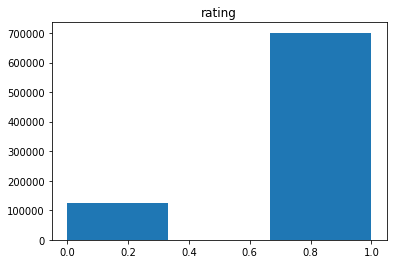

In [9]:
# rating: 1 - товар понравился, 0 - товар не понравился

df['rating'] = df['rating'].astype(int)
plt.hist(df['rating'], bins=3);
plt.title('rating');

In [10]:
df['rating'].value_counts()

1    701088
0    125236
Name: rating, dtype: int64

Пятикратное преимущество товаров, которые понравились.

#### verified

In [11]:
# Признак verified
df['verified'] = df['verified'].astype(int)
df['verified'].value_counts()

1    717641
0    108683
Name: verified, dtype: int64

Количество отзывов от верифицированных пользователей в 7 раз больше, чем от неверифицированных.

#### reviewTime

In [12]:
# Признак reviewTime (07 21, 2016). Разделим на день, месяц, год, день недели

df['reviewTime'] = pd.to_datetime(df['reviewTime'], format="%m %d, %Y")
df['year'] = df['reviewTime'].dt.strftime('%Y').astype(int)
df['month'] = df['reviewTime'].dt.strftime('%m').astype(int)
df['day'] = df['reviewTime'].dt.strftime('%d').astype(int)
df['weekday'] = df['reviewTime'].dt.strftime('%w').astype(int)

In [13]:
df['reviewTime'].describe()

count                  826324
unique                   4580
top       2016-03-01 00:00:00
freq                      909
first     2000-08-09 00:00:00
last      2018-10-02 00:00:00
Name: reviewTime, dtype: object

Первый отзыв был в 2000 году, а последний в 2018. 1 марта 2016 было оставлено 909 отзывов!

In [14]:
df.groupby('reviewTime')['rating'].count().sort_values(ascending=False).head(10)

reviewTime
2016-03-01    909
2016-07-14    858
2015-06-03    769
2016-01-20    763
2016-02-20    753
2016-02-18    738
2016-01-22    729
2016-04-21    723
2016-04-19    721
2017-01-03    717
Name: rating, dtype: int64

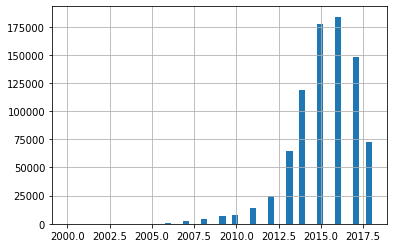

In [15]:
df['year'].hist(bins=50)

Видим рост количества отзывов вплоть до 2016 года. С 2017 заметен спад. Интересно, почему.

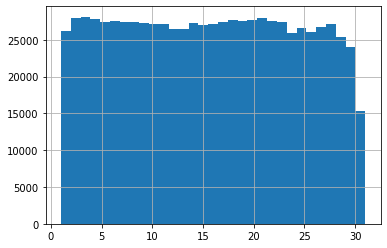

In [16]:
df['day'].hist(bins=31)

Примерно одинаковое количество отзывов каждый день месяца.

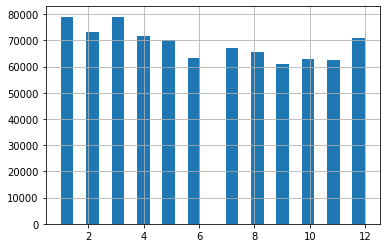

In [17]:
df['month'].hist(bins=24)

С января по март высокий уровень отзывов, потом спад. В декабре снова рост. Скорее всего из-за Рождества и Нового года.

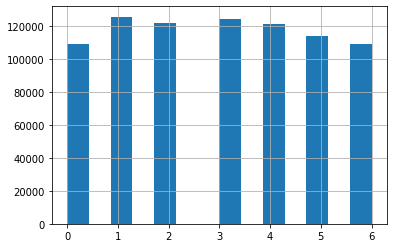

In [18]:
df['weekday'].hist(bins=14)

В выходные (0 и 6) меньше отзывов, чем в будни. Понедельник лидер. 

In [19]:
# Влияет ли день недели на то понравится товар или нет? Практически одинаковые результаты.
df.groupby('weekday')['rating'].mean().sort_values(ascending=False)

weekday
5    0.850884
1    0.850298
3    0.849105
6    0.848167
0    0.847564
2    0.846972
4    0.846055
Name: rating, dtype: float64

#### reviewText

In [20]:
# признак reviewText. Определим длину отзыва.
df['reviewText_len'] = df['reviewText'].str.len()

In [21]:
df['reviewText_len'].describe()

count    826324.000000
mean        208.858114
std         329.942526
min           1.000000
25%          39.000000
50%         112.000000
75%         244.000000
max       19057.000000
Name: reviewText_len, dtype: float64

Максимальное значение - 19057 символов в отзыве!

In [22]:
df['reviewText_len'].sort_values(ascending=False).head()

585803    19057
694225    12589
693267    11901
774702    11900
376005    11665
Name: reviewText_len, dtype: int64

#### summary

In [23]:
# признак summary. Определим длину summary.
df['summary_len'] = df['summary'].str.len()

In [24]:
df['summary_len'].describe()

count    826324.000000
mean         22.379697
std          18.262225
min           1.000000
25%          10.000000
50%          15.000000
75%          29.000000
max         337.000000
Name: summary_len, dtype: float64

#### vote

In [25]:
# признак vote
df['vote'].fillna('0', inplace=True)
df['vote'] = df['vote'].str.replace(',', '')
df['vote'] = df['vote'].astype(int)

In [26]:
df['vote'].describe()

count    826324.000000
mean          0.922824
std           7.922721
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1626.000000
Name: vote, dtype: float64

Максимальное значение - 1626 голоса за отзыв!

In [27]:
df['vote'].sort_values(ascending=False).head()

26646     1626
316141    1491
166361    1383
146565    1157
217372    1060
Name: vote, dtype: int32

Посмотрим на самый полезный отзыв:

In [28]:
df.loc[26646]['reviewText']

"I love these bars...  They are delicious.  Perfect size, portion, etc.  Exactly what I am looking for.  I was a huge fan at first.\n\nNow, I am finding a huge issue with quality control and contamination.  I just discovered Epic Bars within the last 3 weeks.  In that time, I have been to 5 different Whole Foods Markets around the country in 4 different cities because I travel a lot for work.  In each store that carries Epic Bars, there was product which was puffed-up like little pillows.  I am not sure what the issue is EXACTLY.  It seems like some kind of bacterial problem.  I Emailed Epic to tell them about it but they assured me there were no issues going forward.  In fact, they let me know about two chicken flavors that they have: sriracha and sesame BBQ, which was exciting to me.\n\nSo, I trusted them and ordered some product from Amazon.\n\nWhen I received the order, both boxes of chicken flavored bars had contaminated product.  The pictures show an ok package, an infected packa

#### style

Информация об упаковке (метаданные) товара. Много пропусков. Посмотрим на имеющиеся данные:

In [29]:
# признак style.
df['style'][~df['style'].isnull()].head()

1                   {'Size:': ' 60-0.73 oz Envelopes'}
4                              {'Flavor:': ' Jalapeo'}
5    {'Size:': ' Pack of 6', 'Flavor:': ' Organic S...
6    {'Size:': ' 16 Ounce (Pack of 6)', 'Flavor:': ...
8    {'Size:': ' 12 ounce', 'Flavor:': ' Gourmet Ch...
Name: style, dtype: object

#### image

Ссылка на картинку товара. Много пропусков.

In [30]:
df['image'][~df['image'].isnull()].head()

196    ['https://images-na.ssl-images-amazon.com/imag...
261    ['https://images-na.ssl-images-amazon.com/imag...
585    ['https://images-na.ssl-images-amazon.com/imag...
623    ['https://images-na.ssl-images-amazon.com/imag...
635    ['https://images-na.ssl-images-amazon.com/imag...
Name: image, dtype: object

#### userid

In [31]:
# Количество уникальных пользователей
df['userid'].nunique()

127415

#### itemid

In [32]:
# Количество уникальных товаров
df['itemid'].nunique()

41302

### Удаление дубликатов оценок

Один пользователь может оценить товар только один раз.

In [33]:
duplicates = df[df.duplicated(subset = ['itemid','userid'])]
len(duplicates)

14192

In [34]:
df[(df['userid']==83743) & (df['itemid']==6349)]

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
79282,1,2014-03-21,reviewer,"I'm guessing these are fried, not baked. They...","OK, but high calories and fat",1395360000,0,{'Flavor:': ' Caramel'},NaN,83743,6349,1,2014,3,21,5,375,29
811874,1,2014-03-14,reviewer,"These are very light, more like a potato chip ...","Good, but package seems very empty",1394755200,0,{'Flavor:': ' Cinnamon'},NaN,83743,6349,1,2014,3,14,5,681,34


In [35]:
duplicates.index.values

array([  9326,  10863,  11572, ..., 857835, 857836, 857890], dtype=int64)

In [36]:
df = df.drop(duplicates.index.values)

In [37]:
df[(df['userid']==83743) & (df['itemid']==6349)]

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
79282,1,2014-03-21,reviewer,"I'm guessing these are fried, not baked. They...","OK, but high calories and fat",1395360000,0,{'Flavor:': ' Caramel'},NaN,83743,6349,1,2014,3,21,5,375,29


In [38]:
df.shape

(812132, 18)

Посмотрим на корреляции:

In [39]:
corr_matrix = df.corr()
corr_matrix["rating"].sort_values(ascending=False)

rating            1.000000
verified          0.071624
year              0.013189
unixReviewTime    0.012524
weekday           0.000245
day               0.000090
month            -0.005737
userid           -0.010027
itemid           -0.026177
vote             -0.027375
reviewText_len   -0.081787
summary_len      -0.083264
Name: rating, dtype: float64

Есть слабая положительная корреляция с признаком verified и слабая отрицательная связь с длиной отзыва и summary. Чем длиннее отзыв, тем хуже rating.

### Анализ товаров

Сколько оценок у каждого товара?

In [40]:
df.groupby('itemid')['rating'].count().sort_values(ascending=False).head(10)

itemid
22208    4974
23540    4449
24556    4373
32046    2355
29237    1989
1919     1976
379      1923
1378     1913
4689     1898
15137    1499
Name: rating, dtype: int64

Есть очень популярные товары! Добавим эти результаты в датафрейм.

In [41]:
ratings = pd.DataFrame(df.groupby('itemid')['rating'].mean())
ratings['number_ratings'] = df.groupby('itemid')['rating'].count()

Сделаем колонку, в которой посчитаем процент того, понравился ли товар. 100% означает, что абсолютно всем покупателям товар понравился (товар имеет оценки только 4 или/и 5).

In [42]:
ratings['satisfaction'] = (df.groupby('itemid')['rating'].mean() * 100).astype(int)

In [43]:
ratings.head()

,rating,number_ratings,satisfaction
itemid,,,
0,1.000000,8,100
1,0.761905,21,76
2,1.000000,6,100
3,0.905405,74,90
4,0.800000,10,80


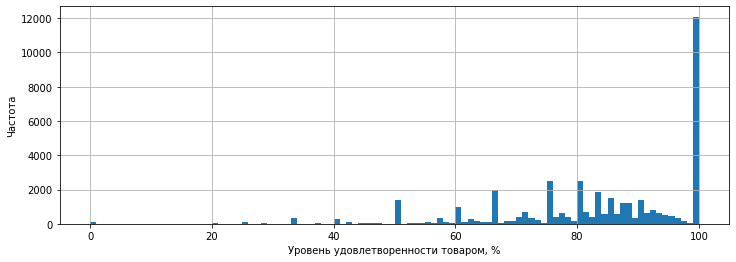

In [44]:
plt.figure(figsize=(12,4))
plt.xlabel('Уровень удовлетворенности товаром, %')
plt.ylabel('Частота')
ratings['satisfaction'].hist(bins=100)

Около 12000 из 41302 товаров понравились абсолютно всем, кто их оценил. Посмотрим на ТОП-10 этих товаров:

In [45]:
ratings[ratings['satisfaction'] == 100].sort_values(by='number_ratings', ascending=False).head(10)

,rating,number_ratings,satisfaction
itemid,,,
13528,1.0,134,100
26310,1.0,110,100
2949,1.0,70,100
29784,1.0,60,100
11996,1.0,57,100
19272,1.0,57,100
20328,1.0,57,100
37168,1.0,55,100
20753,1.0,54,100


Рекордсмен - товар под номером 13528! 134 довольных покупателей.

In [46]:
df[df['itemid'] == 13528].head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
6747,1,2016-09-02,Cheryl Smith,Anyone that loves these things knows how good ...,These are good,1472774400,0,NaN,NaN,21394,13528,1,2016,9,2,5,105,14
12692,1,2015-04-13,Joseph Van Tuggle,great product!!,Five Stars,1428883200,0,NaN,NaN,3150,13528,1,2015,4,13,1,15,10
21864,1,2014-12-08,DR,Just as described!,Five Stars,1417996800,0,NaN,NaN,98204,13528,1,2014,12,8,1,18,10
24558,0,2014-01-07,John L.,To me this is the best hard butterscotch candy...,Werther's,1389052800,0,NaN,NaN,18139,13528,1,2014,1,7,2,267,9
25126,0,2014-08-16,PerpetualLearner,I remember when I was a kid my grandpapa alway...,I used to eat these soft and warm from my gran...,1408147200,0,NaN,NaN,107308,13528,1,2014,8,16,6,279,61


Если пользователь будет выбирать товар данного типа, то можно смело рекомендовать ему этот вид как ХИТ. Таким же образом можно сделать для каждого вида товара, представленного в магазине.

Посмотрим на абсолютных аутсайдеров. Таких 132 штуки:

In [47]:
len(ratings[ratings['satisfaction'] == 0])

132

In [48]:
ratings[ratings['satisfaction'] == 0].sort_values(by='number_ratings', ascending=False).head()

,rating,number_ratings,satisfaction
itemid,,,
17570,0.0,11,0
24428,0.0,6,0
31224,0.0,6,0
5807,0.0,5,0
39284,0.0,5,0


In [49]:
df[df['itemid'] == 17570].head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
52696,1,2011-10-14,owalt,This was a disappointing order. The coffee tas...,Coffee,1318550400,0,{'Size:': ' 48 Count'},NaN,103714,17570,0,2011,10,14,5,172,6
135759,0,2011-10-25,BlueBellBlue,"Like many other reviewers said, it's instant c...",Seems to jam up the machine,1319500800,2,{'Size:': ' 48 Count'},NaN,77481,17570,0,2011,10,25,2,397,27
213649,1,2011-01-21,EdE,Just had my first cup of this coffee. It is s...,Micro Grind,1295568000,7,{'Size:': ' 48 Count'},NaN,50605,17570,0,2011,1,21,5,899,11
367588,1,2011-07-21,Jessica,"These are instant coffee cups, not traditional...",Horrible,1311206400,0,{'Size:': ' 48 Count'},NaN,31714,17570,0,2011,7,21,4,169,8
391197,1,2011-02-22,K.N,It is beyond me why anyone owning a keurig cof...,BUYER BEWARE-INSTANT COFFEE,1298332800,0,{'Size:': ' 48 Count'},NaN,109748,17570,0,2011,2,22,2,816,27


Антилидер магазина - кофе под номером 17570. Товар никому не понравился.

In [50]:
ratings.describe()

,rating,number_ratings,satisfaction
count,41302.000000,41302.000000,41302.000000
mean,0.832686,19.663261,83.002833
std,0.168439,64.970736,16.897517
min,0.000000,1.000000,0.000000
25%,0.750000,5.000000,75.000000
50%,0.857143,8.000000,85.000000
75%,1.000000,16.000000,100.000000
max,1.000000,4974.000000,100.000000


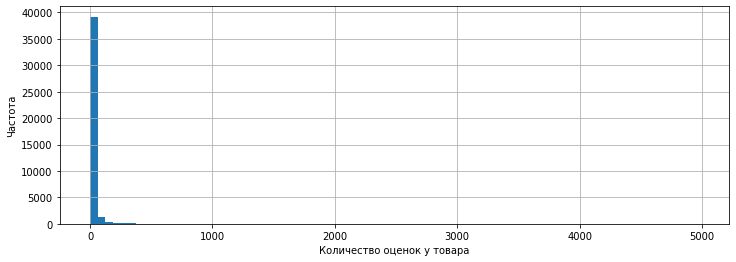

In [51]:
plt.figure(figsize=(12,4))
plt.xlabel('Количество оценок у товара')
plt.ylabel('Частота')
ratings['number_ratings'].hist(bins=80)

75% товаров имеют количество оценок < 16

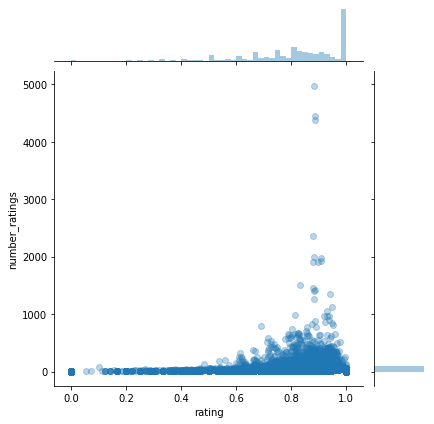

In [52]:
sns.jointplot(x='rating', y='number_ratings', data=ratings, alpha=0.3)

Возьмем товары с количеством оценок больше 150

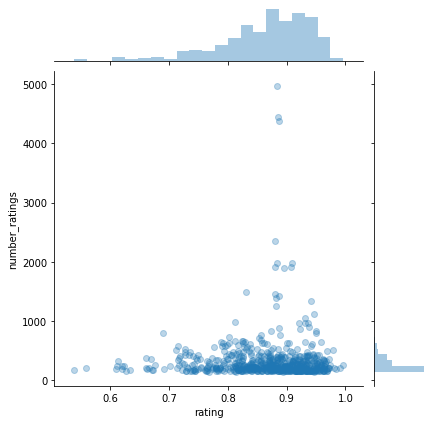

In [53]:
sns.jointplot(x='rating', y='number_ratings', data=ratings[ratings['number_ratings']>150], alpha=0.3)

#### Чем больше оценок, тем выше средний рейтинг товара. Нужно показывать пользователю товары с большим количеством оценок.
Посмотрим на ТОП-10 таких товаров:

In [54]:
ratings.sort_values('number_ratings', ascending=False).head(10)

,rating,number_ratings,satisfaction
itemid,,,
22208,0.884399,4974,88
23540,0.885592,4449,88
24556,0.886348,4373,88
32046,0.880679,2355,88
29237,0.883861,1989,88
1919,0.909413,1976,90
379,0.906916,1923,90
1378,0.879770,1913,87
4689,0.896207,1898,89


Посмотрим на самый продаваемый товар. Это товар с id = 22208. Товар из категории "Snack". Кстати, все товары из ТОП-4 это "Snack".

In [55]:
df[df['itemid'] == 22208].head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
41,1,2017-03-04,E.S.,The dark chocolate and sea salt are a deliciou...,Great taste!,1488585600,0,NaN,NaN,111921,22208,1,2017,3,4,6,60,12
248,1,2017-08-31,booksrock,Delicious! My second favorite Kind bar!,My second favorite Kind bar,1504137600,0,NaN,NaN,123191,22208,1,2017,8,31,4,39,27
400,1,2015-03-02,Sara M. Mclaurin,"delicious; satisfies the sweet tooth. Chewey,...",Yum!,1425254400,0,NaN,NaN,59398,22208,1,2015,3,2,1,80,4
599,1,2013-08-11,C. Simmons,These are my favorite kind bars. They are grea...,These are really good,1376179200,0,NaN,NaN,109335,22208,1,2013,8,11,0,404,21
1119,1,2014-10-30,T. Lee,"Love these! I had heard of Kind bars, but nev...",Love these! I had heard of Kind bars,1414627200,0,NaN,NaN,111187,22208,1,2014,10,30,4,393,36


In [56]:
ratings.reset_index(inplace=True)
ratings

,itemid,rating,number_ratings,satisfaction
0,0,1.000000,8,100
1,1,0.761905,21,76
2,2,1.000000,6,100
3,3,0.905405,74,90
4,4,0.800000,10,80
...,...,...,...,...
41297,41315,0.750000,4,75
41298,41316,1.000000,3,100
41299,41317,0.750000,4,75
41300,41318,1.000000,2,100


Товары с некоторыми id отсутствуют в списке

In [57]:
for i in range(41320):
    if i not in ratings['itemid'].values:
        print(i)

2398
2513
5187
6265
6500
6564
23183
29382
32861
33885
34321
35193
35331
38860
38875
38890
39019
39031


### Анализ пользователей

Посмотрим на средний рейтинг каждого пользователя:

In [58]:
df.groupby('userid')['rating'].mean().sort_values(ascending=False).head()

userid
127495    1.0
58018     1.0
58005     1.0
58006     1.0
58007     1.0
Name: rating, dtype: float64

Сколько товаров оценил каждый пользователь?

In [59]:
df.groupby('userid')['rating'].count().sort_values(ascending=False).head(10)

userid
842      373
355      275
2024     274
2809     249
17987    249
424      202
1874     190
4116     190
888      188
3528     187
Name: rating, dtype: int64

Пользователь "842" очень активен! Соберем все в датафрейм.

In [60]:
users = pd.DataFrame(df.groupby('userid')['rating'].mean())
users['number_ratings'] = df.groupby('userid')['rating'].count()

Сделаем колонку, в которой посчитаем процент того, понравился ли товар. 100% означает, что абсолютно все товары понравились пользователю (товар имеет оценки только 4 или/и 5).

In [61]:
users['satisfaction'] = (df.groupby('userid')['rating'].mean() * 100).astype(int)
users.head()

,rating,number_ratings,satisfaction
userid,,,
0,1.000000,2,100
1,0.866667,15,86
2,0.888889,18,88
3,0.857143,7,85
4,0.833333,6,83


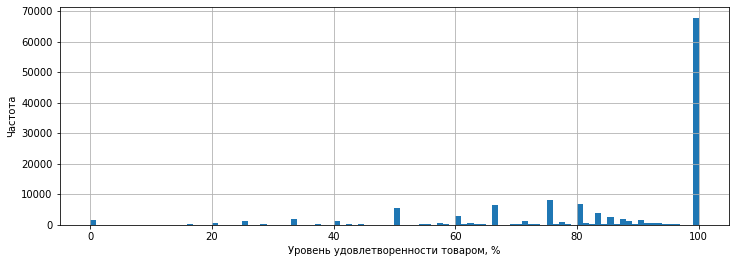

In [62]:
plt.figure(figsize=(12,4))
plt.xlabel('Уровень удовлетворенности товаром, %')
plt.ylabel('Частота')
users['satisfaction'].hist(bins=100)

Почти 70000 пользователей довольны каждым приобретенным товаром.

In [63]:
users[users['satisfaction'] == 100].sort_values(by='number_ratings', ascending=False).head()

,rating,number_ratings,satisfaction
userid,,,
13024,1.0,174,100
7336,1.0,87,100
19142,1.0,81,100
2430,1.0,73,100
29399,1.0,66,100


Рекордсмен - пользователь с id 13024. Все 174 товара ему понравились.

In [64]:
df[df['userid'] == 13024].head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
4640,0,2015-03-17,Madison T. Edwards,This is my official bed time tea! I love the t...,Love It,1426550400,0,NaN,NaN,13024,1919,1,2015,3,17,2,225,7
13328,0,2015-06-24,Madison T. Edwards,"I love this oatmeal! I love the original, but...",Good,1435104000,0,{'Flavor:': ' Peaches and Cream'},NaN,13024,9090,1,2015,6,24,3,225,4
13990,0,2015-05-28,Madison T. Edwards,Great tasting peanut butter! This is a very go...,Yummy,1432771200,0,NaN,NaN,13024,743,1,2015,5,28,4,187,5
18122,0,2015-05-23,Madison T. Edwards,"Spicy!! This is excellent for cheese dip, taco...",Spicy!,1432339200,0,NaN,NaN,13024,18872,1,2015,5,23,6,195,6
20141,0,2015-05-19,Madison T. Edwards,This is a very good snack! Good without being ...,Good,1431993600,0,NaN,NaN,13024,11088,1,2015,5,19,2,105,4


Посмотрим на пользователей, которым ничего не нравится. Таких 1717:

In [65]:
len(users[users['satisfaction'] == 0])

1717

In [66]:
users[users['satisfaction'] == 0].sort_values(by='number_ratings', ascending=False).head()

,rating,number_ratings,satisfaction
userid,,,
17806,0.0,21,0
37786,0.0,18,0
37066,0.0,13,0
1453,0.0,13,0
72728,0.0,12,0


In [67]:
df[df['userid'] == 17806].head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
6418,0,2012-12-08,The public,Kelloggs uses GMO's in their products. GMO's h...,GMO is POISON,1354924800,0,NaN,NaN,17806,17830,0,2012,12,8,6,348,13
14700,0,2012-12-08,The public,Silks parent company contributed to the millio...,GMO's are Poison,1354924800,0,"{'Size:': ' 32 Ounce (Pack of 6)', 'Flavor:': ...",NaN,17806,33412,0,2012,12,8,6,567,16
28854,0,2012-12-09,The public,GMO's cause cancer and organ failure. Save you...,GMO's are poison,1355011200,6,NaN,NaN,17806,29319,0,2012,12,9,0,306,16
58478,0,2012-12-09,Gerard S. Wilson,This product contains GMO's Known to cause Can...,GMO's cause Cancer,1355011200,0,NaN,NaN,17806,9086,0,2012,12,9,0,179,18
209539,0,2012-12-11,The public,Wow made from corn and may contain soy? That's...,Protect your health,1355184000,3,{'Package Quantity:': ' 4'},NaN,17806,17233,0,2012,12,11,2,471,19


In [68]:
users.describe()

,rating,number_ratings,satisfaction
count,127415.000000,127415.000000,127415.000000
mean,0.846896,6.373912,84.558710
std,0.217017,6.178848,21.766451
min,0.000000,1.000000,0.000000
25%,0.750000,4.000000,75.000000
50%,1.000000,5.000000,100.000000
75%,1.000000,7.000000,100.000000
max,1.000000,373.000000,100.000000


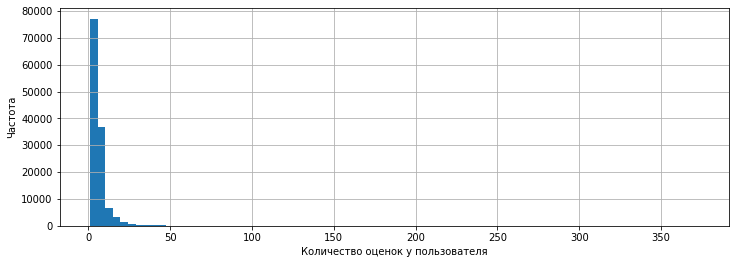

In [69]:
plt.figure(figsize=(12,4))
plt.xlabel('Количество оценок у пользователя')
plt.ylabel('Частота')
users['number_ratings'].hist(bins=80)

75% пользователй имеют количество оценок < 7

Половина пользователей имеет среднюю оценку больше 4.66.

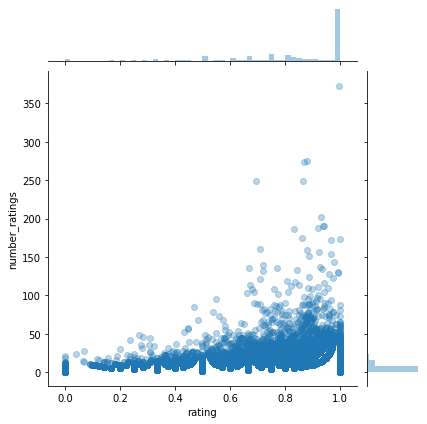

In [70]:
sns.jointplot(x='rating', y='number_ratings', data=users, alpha=0.3)

Возьмем пользователей с количеством оценок больше 10

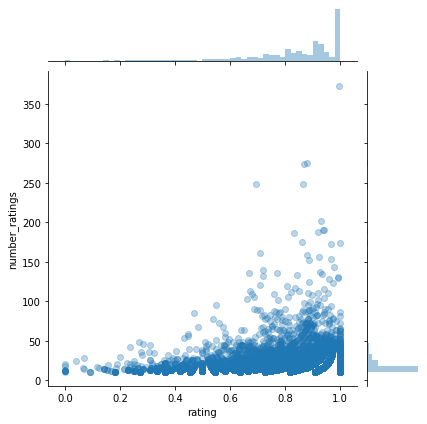

In [71]:
sns.jointplot(x='rating', y='number_ratings', data=users[users['number_ratings']>10], alpha=0.3)

Чем больше оценок ставит пользователь, тем выше у него средний рейтинг.

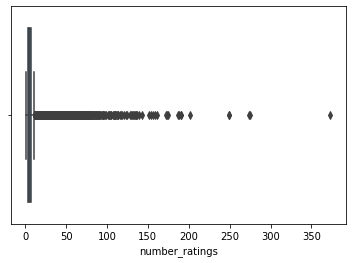

In [72]:
sns.boxplot(x=users["number_ratings"])

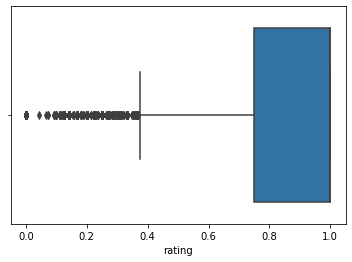

In [73]:
sns.boxplot(x=users["rating"])

Посмотрим на ТОП-10 пользователей по количеству оценок:

In [74]:
users.sort_values('number_ratings', ascending=False).head(10)

,rating,number_ratings,satisfaction
userid,,,
842,0.994638,373,99
355,0.880000,275,88
2024,0.868613,274,86
2809,0.694779,249,69
17987,0.863454,249,86
424,0.930693,202,93
4116,0.936842,190,93
1874,0.942105,190,94
888,0.920213,188,92


Посмотрим на пользователя "842" поближе

In [75]:
df[df['userid']==842].head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
954,0,2014-11-29,Doug Erlandson,These tasty Jelly Belly licorice pastels have ...,Tasty snack,1417219200,2,NaN,NaN,842,2818,1,2014,11,29,6,677,11
3486,0,2013-12-26,Doug Erlandson,I've tasted a number of different caramels ove...,None better,1388016000,2,{'Flavor:': ' Soft Vanilla'},NaN,842,17923,1,2013,12,26,4,733,11
8098,0,2013-11-04,Doug Erlandson,I've been in love with Dutch licorice for more...,Among my favorites,1383523200,2,NaN,NaN,842,39018,1,2013,11,4,1,1385,18
8172,0,2014-10-10,Doug Erlandson,Until recently I had never tasted almond butte...,Tasty and better for you than peanut butter,1412899200,8,NaN,NaN,842,30642,1,2014,10,10,5,668,43
9859,0,2017-03-06,Doug Erlandson,"Forty years ago, when I became interested in e...",Wouldn't use any other type of sugar,1488758400,2,{'Size:': ' 500 Count'},NaN,842,1479,1,2017,3,6,1,565,36


Doug Erlandson оценил 373 товаров и уровень его удовлетворенности 99%!

In [76]:
users.reset_index(inplace=True)

In [77]:
where_userid = []
for i in range(127496):
    if i not in users['userid'].values:
        where_userid.append(i)

Некторые userid отсутствуют в списке.

In [78]:
print(where_userid)

[4801, 5708, 8472, 8939, 10625, 11762, 13457, 13514, 15637, 16043, 17487, 19827, 20032, 20981, 21240, 24268, 24468, 25554, 26208, 28498, 29544, 31744, 37516, 38827, 39257, 39470, 42030, 42383, 45620, 46487, 48843, 49473, 49909, 51040, 54378, 54550, 57945, 59255, 59322, 60084, 62284, 62706, 62974, 63436, 64975, 69670, 70039, 71746, 72574, 74166, 74497, 74546, 76398, 76863, 77008, 77269, 79430, 80333, 81623, 82152, 84259, 86708, 88531, 92058, 93047, 96737, 100375, 101379, 103223, 104451, 107300, 107656, 111078, 115439, 118332, 121472, 121513, 123180, 123874, 125499, 127484]


### Создание категории товара
Для каждого товара создадим теги, характеризующие данный товар. Информацию будем брать из отзывов пользователей. Для начала создадим датафрейм из возможных тегов для продуктового магазина.

In [124]:
tags = "coffee, tea, soda, coconut, energy, сereal, snack, chocolate, beer, cocktail, vodka, wine, bakery, \
dessert, bread, cake, cookie, pastrie, pizza, dough, toaster, syrup, flakes, muesli, pancake, waffle, baking, \
toffee, caramel, candied, candy, gum, fudge, lollipop, jelly, marshmallow, mint, sour, sweets, biscuit, \
breakfast, dairy, butter, margarine, cheese, sauce, cream, egg, milk, lunche, yogurt, appetizer, pie, \
quich, meat, salad, salsa, pasta, meal, olive, antipasto, sandwiche, soup, stew, chili, nut, fruit, jam, juice, \
vegetable, potato, tomato, peach, strawberry, vanilla, cherry, blueberry, bacon, beef, chicken, lamb, \
pork, sausage, turkey, jerky, burger, loaves, roasts, \
meatballs, nugget, cutlet, tofu, rice, bean, noodle, vegetarian, herb, protein, vegan, gluten, organic, bar, \
seed, cracker, popcorn, pretzel, chips, wasabi"

tags = tags.replace(' ', '').split(',')
len(tags)

108

In [125]:
tags_dict = {}
for ind, tag in enumerate(tags):
    tags_dict[ind] = tag
    
df_tags = pd.DataFrame(tags_dict.items(), columns=['tag_id', 'tag'])
df_tags.head()

,tag_id,tag
0,0,coffee
1,1,tea
2,2,soda
3,3,coconut
4,4,energy


Создадим датафрейм с полями itemid, tag_id. Например, у товара 12 есть теги 2,5,7. Этот датафрейм будем использовать для обучения модели в качестве признаков товара.

In [126]:
def find_intersections(row):
    """ Принимает строку датафрейма. 
        Заполняет список парами tuple (itemid, tag_id).
    """
    for tag in df_tags['tag']:
        if tag in row['reviewText'].lower():
            tag_id = df_tags[df_tags['tag'] == tag]['tag_id'].values[0]
            pair = (row['itemid'], tag_id)
            list_items_tags.append(pair)

In [127]:
list_items_tags = []
_ = df.apply(lambda row: find_intersections(row), axis=1)

In [128]:
len(list_items_tags)

995086

In [129]:
items_tags = set(list_items_tags)

In [130]:
len(items_tags)

300880

In [131]:
df_items_tags = pd.DataFrame(items_tags, columns=['itemid', 'tag_id'])

In [132]:
df_items_tags.head()

,itemid,tag_id
0,1760,65
1,19733,14
2,4651,48
3,23235,2
4,727,68


In [133]:
# сохраним в виде csv-файла
df_items_tags.to_csv('items_tags.csv', index = False)

Посмотрим на товары с наибольшим количеством тегов.

In [134]:
tags_info = df_items_tags.groupby('itemid')['tag_id'].count()
tags_info.describe()

count    39990.000000
mean         7.523881
std          6.978213
min          1.000000
25%          3.000000
50%          5.000000
75%         10.000000
max         67.000000
Name: tag_id, dtype: float64

75% товаров имеют меньше 10 тегов.

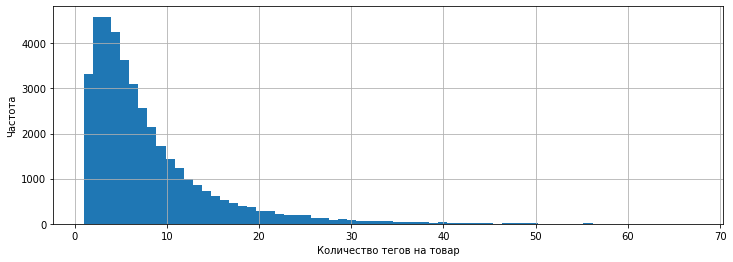

In [136]:
plt.figure(figsize=(12,4))
plt.xlabel('Количество тегов на товар')
plt.ylabel('Частота')
tags_info.hist(bins=67)

In [137]:
tags_info.sort_values(ascending=False).head()

itemid
16833    67
26736    67
18620    66
15365    65
3927     65
Name: tag_id, dtype: int64

Посмотрим на товар с id 16833

In [138]:
df_items_tags[df_items_tags['itemid'] == 16833].head().merge(df_tags, left_on='tag_id', right_on='tag_id')

,itemid,tag_id,tag
0,16833,1,tea
1,16833,48,milk
2,16833,101,bar
3,16833,70,potato
4,16833,39,biscuit


In [139]:
df[df['itemid'] == 16833].head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
1354,1,2014-09-29,Lizzi - Florida,This upset my tummy a bit but the cheesy biscu...,Biscuits were good. Pizza crust not so great.,1411948800,0,{'Size:': ' 3 lb Box'},NaN,83048,16833,1,2014,9,29,1,306,45
2175,1,2018-04-30,Elizabeth,My pantry will never not have this in it.,Five Stars,1525046400,0,{'Size:': ' 3 lb Box'},NaN,114744,16833,1,2018,4,30,1,41,10
3059,1,2014-07-10,Tony V,Great alternative to all purpose flour for tho...,Great alternative to all purpose flour for tho...,1404950400,0,{'Size:': ' 3 lb Box'},NaN,52792,16833,1,2014,7,10,4,278,57
3201,1,2014-05-16,NEVER AGAIN,good item and cheap price .,Five Stars,1400198400,0,{'Size:': ' 3 lb Box'},NaN,38945,16833,1,2014,5,16,5,27,10
4788,1,2017-12-03,joe,Makes great low carb biscuits.,Five Stars,1512259200,0,{'Size:': ' 3 lb Box'},NaN,5511,16833,1,2017,12,3,0,30,10


Посмотрим на самые популярные теги.

In [141]:
tags_pop = df_items_tags.merge(df_tags, left_on='tag_id', right_on='tag_id')

In [142]:
tags_pop['tag'].value_counts()

rice         23429
nut          15136
tea          14652
coffee        8621
pie           8222
             ...  
lollipop       170
muesli          98
quich           55
cutlet          35
antipasto       23
Name: tag, Length: 107, dtype: int64

Лидеры rice, nut и tea 

## Обучаем модель

In [143]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

In [144]:
train_data, test_data = train_test_split(df, random_state=32, shuffle=True)

In [145]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))
ratings_coo

<127496x41319 sparse matrix of type '<class 'numpy.int32'>'
	with 609099 stored elements in COOrdinate format>

In [146]:
feature_ratings = sparse.coo_matrix(([1]*len(df_items_tags),(df_items_tags.itemid, df_items_tags.tag_id)))
feature_ratings

<41320x108 sparse matrix of type '<class 'numpy.int32'>'
	with 300880 stored elements in COOrdinate format>

In [147]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 108 #число параметров вектора 
NUM_EPOCHS = 5 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS,
                  item_features=feature_ratings,
                  verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [148]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values,
                      item_features=feature_ratings
                     )

In [149]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.67096687482136

Попробуем другой loss

In [150]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 5 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='warp',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS,
                  item_features=feature_ratings,
                  verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [151]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values,
                      item_features=feature_ratings
                     )

In [152]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.5114649253283032

Попробуем другой learning_rate

In [153]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 60 #число параметров вектора 
NUM_EPOCHS = 5 #число эпох обучения

model = LightFM(learning_rate=0.05, loss='logistic', no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS,
                  item_features=feature_ratings,
                  verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [155]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values,
                      item_features=feature_ratings
                     )
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.6793627108722721

#### Обучим модель на всех данных.

In [156]:
ratings_coo = sparse.coo_matrix((df['rating'].astype(int),
                                 (df['userid'],
                                  df['itemid'])))
ratings_coo

<127496x41320 sparse matrix of type '<class 'numpy.int32'>'
	with 812132 stored elements in COOrdinate format>

In [157]:
feature_ratings = sparse.coo_matrix(([1]*len(df_items_tags),(df_items_tags.itemid, df_items_tags.tag_id)))
feature_ratings

<41320x108 sparse matrix of type '<class 'numpy.int32'>'
	with 300880 stored elements in COOrdinate format>

In [158]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 30 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.05, loss='logistic', no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS,
                  item_features=feature_ratings,
                  verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [159]:
# Достаём эмбеддинги
item_biases, item_embeddings = model.get_item_representations(features=feature_ratings)

In [160]:
item_embeddings.shape

(41320, 30)

In [161]:
import nmslib

#Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')

#Начинаем добавлять наши книги в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

#Вспомогательная функция для поиска по графу

def nearest_items_nms(item_id, index, n=10):
    nn = index.knnQuery(item_embeddings[item_id], k=n)
    return nn

#### Проверяем модель

Давайте попробуем написать рекомендации к товару в категории pizza.

In [181]:
df_tags[df_tags['tag']=='pizza']

,tag_id,tag
18,18,pizza


In [182]:
df_items_tags[df_items_tags['tag_id'] == 18].merge(df_tags, left_on='tag_id', right_on='tag_id')

,itemid,tag_id,tag
0,9831,18,pizza
1,32384,18,pizza
2,18219,18,pizza
3,32002,18,pizza
4,6823,18,pizza
...,...,...,...
1094,10841,18,pizza
1095,15177,18,pizza
1096,143,18,pizza
1097,38380,18,pizza


In [185]:
df_items_tags[df_items_tags['itemid'] == 143].merge(df_tags, left_on='tag_id', right_on='tag_id')

,itemid,tag_id,tag
0,143,47,egg
1,143,62,soup
2,143,92,rice
3,143,55,salad
4,143,85,burger
5,143,22,flakes
6,143,1,tea
7,143,70,potato
8,143,65,nut
9,143,57,pasta


In [191]:
nearest_items = nearest_items_nms(1, nms_idx)[0]
nearest_items

array([   17,  4565,  6434, 11779, 28426, 33885, 39339, 37859, 39433,
       39778])

In [192]:
#Выводим похожие товары.

df[df['itemid'].isin(nearest_items)].head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating,year,month,day,weekday,reviewText_len,summary_len
18984,1,2018-05-01,bradley pocock,"Good stuff, Thank you.",Five Stars,1525132800,0,NaN,NaN,16323,11779,1,2018,5,1,2,22,10
42431,1,2014-08-26,VT,Garlic is small so most cloves are tiny.,Three Stars,1409011200,0,NaN,NaN,53792,11779,0,2014,8,26,2,40,11
49139,1,2017-05-28,TechSteph,This is my favorite sparkling water! Perfect ...,Best sparkling water ever!!!,1495929600,0,NaN,NaN,73933,37859,1,2017,5,28,0,257,28
51130,1,2017-01-15,Robin,Accurately described - good value - fast shipp...,Ok for high volume use - not for prolonged use,1484438400,0,NaN,NaN,441,17,1,2017,1,15,0,230,46
74652,0,2016-08-29,Celia Rutherford,This watermelon spears are good for you as wel...,Taste good,1472428800,0,NaN,NaN,39795,28426,1,2016,8,29,1,62,10


Подготовим свою модель к внедрению в продакшен

In [164]:
import pickle
with open('item_embeddings_2.pickle', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

Делаем submission

In [165]:
test = pd.read_csv('data3/test_v3.csv', low_memory=False)

In [167]:
preds = model.predict(test.userid.values,
                      test.itemid.values,
                     item_features=feature_ratings)

In [168]:
preds.min(), preds.max()

(-38.92748260498047, 74.69732666015625)

In [169]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds.min(), normalized_preds.max()

(0.0, 1.0)

In [170]:
submission = pd.read_csv('data3/sample_submission.csv')

In [171]:
submission['rating']= normalized_preds

In [172]:
submission.head()

,Id,rating
0,0,0.401176
1,1,0.370891
2,2,0.422314
3,3,0.367452
4,4,0.439210


In [173]:
# сохраним в виде csv-файла
submission.to_csv('submission_8.csv', index = False)

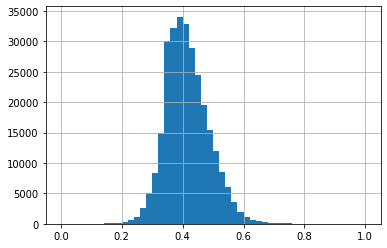

In [174]:
submission['rating'].hist(bins=50)

### Выводы

- Пользователям нужно показывать товары с наибольшим количеством оценок других пользователей. Чем больше оценок, тем больше средний рейтинг товара. Товары, которые никому не понравились раньше, скорее всего не понравятся и текущим пользователям (при условии, что товар был оценен несколькими пользователями). 
- Если у товара давно не было свежих оценок, то он должен иметь меньший приоритет при показе, чем товар со свежими оценками.
- Самый часто оцениваемый товар - это товар из категории "Snack". Все товары из ТОП-4 это "Snack".
- Самые встречающиеся теги у товаров: rice, nut и tea.
- Если пользователь еще не оценивал товары (новый пользователь), то ему можно показывать популярные товары из той же категории, которую он сейчас смотрит.
- Эффективность от внедрения модели в реальную работы можно оценить с помощью A/B-тестирования. Одна группа пользователей будет получать рекомендации на сайте, а другая нет. Через заранее определенный срок следует сделать выводы, увеличился ли средний чек покупателя, который получал рекомендации или нет.

Для улучшения показателей системы можно:
- усовершенствовать способ определения тегов для товара,
- создать признаки, характеризующие пользователя (напрмер, верифицирован ли пользователь)
- попробовать обучить модель, используя другие библиотеки, 